# Propensity Score Matching: A Practitioner's Appendium


## TL;DR
This article discusses the usage and a common pitfall of the Propensity Score Matching (PSM) from a working data scientist's perspective in the language that (hopefully) is accessible to most data scientists that are familar with causal inference.

1. In a simulation exercise, I show PSM can be used to remove functional form dependence.
1. The key assumption in matching is the ignorability assumption. I show why you want to make sure this assumption holds.
1. I propose a user friendly way to test the ignorability assumption.
1. Code snippets using Python libraries that are familiar to most data scientists are provided.


## Introduction

TBD

### A Note on the Terminalogy
- Treatment: intervention, TODO add more
- Propensity score, or simply propensity: the probability of being treated
- Outcome: the metric you care about, typically your primary business metric that you're hoping to optimize

In [4]:
# Google's colab has a older version of lightgbm, which
# is not compatible with the outcome model's code
!pip uninstall -y lightgbm
!pip install lightgbm

Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0MB 4.0MB/s 


Your usual imports.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
from scipy.special import expit
import seaborn as sns
import statsmodels.formula.api as smf
import lightgbm as lgb
from sklearn.feature_selection import mutual_info_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's generate some simulation data to play with.

In [2]:
np.random.seed(0)
N = 10_000
df = pd.DataFrame(
    np.random.rand(N, 6),
    columns=list('abcdef'),
)
df['true_ps'] = expit(df['a'] + 3 * df['b'] - 0.2 * df['c'] - 2 * df['f'])
df['treatment'] = bernoulli.rvs(df['true_ps'])
df['outcome'] = (
    (
        15 * df['a'] / np.exp(df['c'])) ** df['b'] 
        + (0.7 * np.sin(df['b']) 
        - 0.3 * np.exp(df['c']) ** 2
    ) + np.random.normal(size=N)
)
df.head()

,a,b,c,d,e,f,true_ps,treatment,outcome
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.782797,0,1.740649
1,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.865575,0,0.953746
2,0.568045,0.925597,0.071036,0.087129,0.020218,0.832620,0.840960,1,6.752207
3,0.778157,0.870012,0.978618,0.799159,0.461479,0.780529,0.836363,1,3.800730
4,0.118274,0.639921,0.143353,0.944669,0.521848,0.414662,0.764956,1,1.983770


Note that here I generated 6 features. The true propensity score (`true_ps`) follows a standard logistic form (`expit` is just the Sigmoid function) so that we do not need a sophisticated non-linear model on the propensity score. The `treatment` column indicates the binary intervention. The `outcome` column is the metric we care about. In a business context, it means a business metric that we're trying to move through the intervention.

As you can see, the relationship between the `outcome` and the features is highly non-linear. It turns out this is necessary for the point I'm about to make. In reality, however, the relationship between your business metric and your features might be more complex. But, importantly, the `outcome` has nothing to do with the `treatment`. In other words, the true treatment effect is zero throughout the board.

In practice, we would observe all the 6 features, the treatment label, and the outcome column. But we would not know the true propensity score, or the functional forms that generate the true propensity score or the outcome.

In [3]:
df['treatment'].sum()

6669

The following is the relationship between the true propensity score and the treatment. Not surprisingly, data points being treated have higher propensity scores in general.

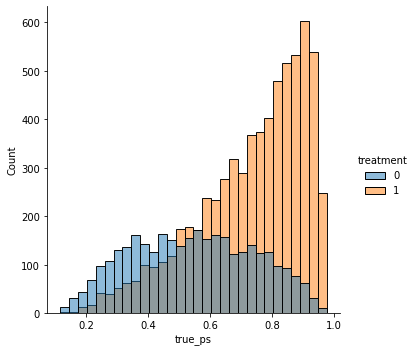

In [4]:
sns.displot(df, x='true_ps', hue='treatment')

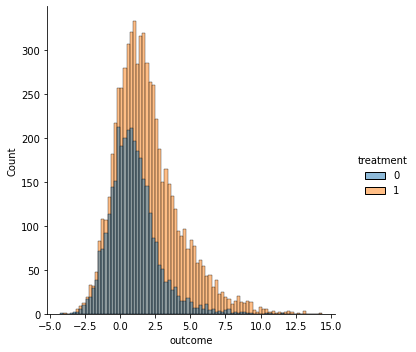

In [5]:
sns.displot(df, x='outcome', hue='treatment')

Suppose a data scientist has correctly identified `a` to `f` as confounding features and decides to include the confounding features in their analysis. Following the common practice, they run a regression on the treatment label and all the confounding features, as follows.

In [6]:
print(smf.ols('outcome ~ treatment + a + b + c + d + e + f', data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2333.
Date:                Wed, 26 May 2021   Prob (F-statistic):               0.00
Time:                        22:22:11   Log-Likelihood:                -17104.
No. Observations:               10000   AIC:                         3.422e+04
Df Residuals:                    9992   BIC:                         3.428e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3330      0.060     -5.536      0.0

The model incorrectly attributes a `-0.1` effect to the treatment, and it is statistically significant under all conventional thresholds. The data scientist would conclude the treatment negatively impact the outcome.

Why? In this model the confounders enter the regression in a linear way. Because the functional form is not able to fully capture the true relationship (the nonlinear one we cooked up in the data generating part) and the treatment label is correlated with those confounding features, some of the nonlinear effects are attributed to the treatment.

Can a nonlinear model help? Well maybe. If the model were correctly specificed (i.e., has the correct functional form), then the model would be able to tell the true treatment effect is zero. But without knowing the true relationship, this is unlikely to happen.

We can use propensity score matching to remove the model uncertainty.

TODO: Explain (King et al.?)

Let's first build a propensity score model. Because we only consider binary treatment here, a propensity score model is just a binary classifier that can make probability predictions. 

Here I will cheat a little bit. I run a simple (means not regularized) logistic regression as the propensity score model. Because we already know the data generating process of the propensity score, this is the most efficient model. 

In a real problem, you may want to use a more capable binary classifier. If you decide to train a more ML-like binary classifier, then you still want to follow the best practices on the bias and variance tradeoff. In this use case, however, we do not care about accuracy/precision/recall/f1 or any other evaulation metrics that only compare binary predictions against their labels. Instead, you want to choose a evaulation metric that captures prediction probabilities. The good old "log loss" is usually a good choice.

In [7]:
ps_model = smf.logit('treatment ~ a + b + c + d + e + f', data=df).fit()
print(ps_model.summary())

Optimization terminated successfully.
         Current function value: 0.535076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.1592
Time:                        22:22:18   Log-Likelihood:                -5350.8
converged:                       True   LL-Null:                       -6363.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0139      0.100     -0.139      0.890      -0.211       0.183
a              1.0020      0.

The predicted propensity score is simply the probability prediction of the model made on the training set. Do not worry about the traiditional ML's insistence on the out-of-sample prediction in this case.

In [8]:
# produce the propensity score
df['_score'] = ps_model.predict()

### Pairing up from the Predictions

I use the following algorithm to form matched paris. In the literature, this method is called the nearest neighbor with a caliper. It is a greedy algorithm. It iteratively forms pairs with the closest matches that are within a certain threshold (caliper) without replacement. You can also go for the optimal matching that minimizes the average distance within pairs, although studies (e.g., Gu and Rosenbaum, 1993) show their empirical performances are typically on par with each other. 

In [9]:
def match(
    data: pd.DataFrame, 
    threshold: float = 0.001, 
    treatment_col: str = "treatment", 
    score_col: str = "_score"
) -> pd.DataFrame:
    """
    Finds a suitable pair for each record in the dataset, if one exists.
    Records are excluded from the final matched dataset if there are no suitable matches.
    """
    assert score_col in data.columns, "Propensity Scores have not been calculated"

    pairs = {}
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    # Because nearest neighbor matching is greedy,
    # doing a random shuffle here to remove structures in the data (if any)
    for index, score in treated[score_col].sample(frac=1).iteritems():
        diff = (control[score_col] - score).abs().sort_values()
        for candidate_index, delta in diff.iteritems():
            # because diff is sorted, we can assure
            # there's no valid pair if delta is larger than threshold
            if delta > threshold:
                break
            # candidate has already formed a match
            if candidate_index in pairs:
                continue
            pairs[candidate_index] = index

    match_id = 0
    for control_index, treated_index in pairs.items():
        data.at[control_index, "_match_id"] = match_id
        data.at[treated_index, "_match_id"] = match_id
        match_id += 1
    return data[data["_match_id"].notnull()]

Let's take a peek of the post match data. The `_score` column is the predicted propensity score. As expected, it is close to the true score. The column `_match_id` is the id of the pair. Two rows that form a comparable pair in this dataframe share one id.

Notice that the size of the matched sample is much smaller because we dropped all the single data points.

In [10]:
matched_df = match(df)
print(f"Size of the matched sample: {len(matched_df)}")
matched_df.head()

Size of the matched sample: 3874


,a,b,c,d,e,f,true_ps,treatment,outcome,_score,_match_id
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.782797,0,1.740649,0.781791,252.0
1,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.865575,0,0.953746,0.867669,1068.0
5,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.779156,0,2.227795,0.778735,1928.0
6,0.612096,0.616934,0.943748,0.681820,0.359508,0.437032,0.802197,1,-0.514348,0.801336,1570.0
7,0.697631,0.060225,0.666767,0.670638,0.210383,0.128926,0.619423,0,-0.018675,0.611799,2101.0


On this matched sample, let's run the original regression again and see if the result is any different.

In [11]:
print(smf.ols('outcome ~ treatment + a + b + c + d + e + f', data=matched_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     600.1
Date:                Wed, 26 May 2021   Prob (F-statistic):               0.00
Time:                        22:22:32   Log-Likelihood:                -6243.0
No. Observations:                3874   AIC:                         1.250e+04
Df Residuals:                    3866   BIC:                         1.255e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1959      0.085      2.317      0.0

Look at the coefficient on the treatment. This time we correctly fail to reject the treatment effect being zero.

This shows the effectiveness of propensity score matching.

## The Ignorability Assumption

The ignorability (also known as unconfoundedness, conditional independence, or selection on observables) assumption means we have included all the features that affect both the outcome and the treatment assignment in our models. This is a tricky assumption because it is super duper important and yet very hard to test. You can check [this](https://arxiv.org/pdf/2012.15716.pdf) 80-page and full-of-math paper if you feel learning something. I'll give you a simple procedure to test this assumption using only `scikit-learn`. But before we do this, let me first emphasize its importance.

### The Violation of the Ignorability Assumption

Not all problems in data science are sensitive to assumptions. Therefore, maybe not all of your fellow data scientists are allergic to skipping tests on assumptions. How bad can it be if we fail to includes some features that affects the treatment assignment and the outcome? We lose 1% of model performance? Who cares? 

Well the answer is the estimated treatment effect can be biased. This bias can lead to qualitatively incorrect business decisions that might cost you millions.

In the following simulation, let's not include `a` and `b` for some reason. From the data generating process, we know both of them are critical for the propensity and the outcome equations. Therefore, we're violating the ignorability assumption. Is this a big deal? Let's find out.

We run the propensity score model, generate the propensity score prediction, and do the matching as usual.

In [12]:
# The suffix `ov` means omitted variable bias.
# The name comes from that we have omitted important variables.
ps_model_ov = smf.logit('treatment ~ c + d + e + f', data=df).fit()
print(ps_model_ov.summary())
df['_score_ov'] = ps_model_ov.predict()

Optimization terminated successfully.
         Current function value: 0.609952
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Wed, 26 May 2021   Pseudo R-squ.:                 0.04149
Time:                        22:25:22   Log-Likelihood:                -6099.5
converged:                       True   LL-Null:                       -6363.5
Covariance Type:            nonrobust   LLR p-value:                5.868e-113
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6560      0.081     20.360      0.000       1.497       1.815
c             -0.1459      0.

In [13]:
matched_df_ov = match(df, score_col="_score_ov")
print(f"Size of the matched sample: {len(matched_df_ov)}")
matched_df_ov.head()

Size of the matched sample: 4263


,a,b,c,d,e,f,true_ps,treatment,outcome,_score,_match_id,_score_ov
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.782797,0,1.740649,0.781791,1585.0,0.613539
1,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.865575,0,0.953746,0.867669,2688.0,0.653544
5,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.779156,0,2.227795,0.778735,2079.0,0.624952
6,0.612096,0.616934,0.943748,0.681820,0.359508,0.437032,0.802197,1,-0.514348,0.801336,1570.0,0.682797
7,0.697631,0.060225,0.666767,0.670638,0.210383,0.128926,0.619423,0,-0.018675,0.611799,1596.0,0.791112


Then, same as before, we run the outcome regression with the matched data.

In [14]:
print(smf.ols('outcome ~ treatment + c + d + e + f', data=matched_df_ov).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     186.6
Date:                Wed, 26 May 2021   Prob (F-statistic):          3.97e-180
Time:                        22:25:28   Log-Likelihood:                -8203.2
No. Observations:                4263   AIC:                         1.642e+04
Df Residuals:                    4257   BIC:                         1.646e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1580      0.098     21.935      0.0

The model attributes `0.5` to the treatment (and this number is statistically significant in all conventional significance levels). If we were to make business decisions based on this analysis, we would reach a false conclusion and potentially lose a lot.

Why we end up with `0.5` on the treatment's coefficient? Because `a` and `b` are important to the outcome and yet we do not include them, the regression tries to attribute some of their effects on the treatment label, which is correlated with `a` and `b`.

In summary, we violate the ignorability assumption and the estimated treatment effect can be much biased. 

## How do we test ignorability?

Now we know we should really treat the ignorability seriously. But how do we know if we meet this assumption or not?

At first sight, the ignorability assumption is difficult to test: How do you test if you have included enough relevant features?

To achieve this, we need to utilize the residuals. For any model, residuals contain information that cannot be attributed to the included features. In other words, residuals summarizes the unobserved features that would be relevant to the model if they were included. 

To perform tests on the ignorability assumption, we need to build the outcome model as well. If the ignorability assumption holds, then we should expect the residuals of the propensity model and the outcome model are independent because we have already included features that are critical to both. Conversely, we know we have missed something important.

For the informed readers, the idea is inspired by the Heckman selection model. 

Let's code it up and put this idea into test.

Because the data generating process for the outcome is nonlinear, we need a model that can capture a flexible functional form. Here I choose LightGBM simply because I'm currently playing with LightGBM. You should feel free to choose others (e.g., XGBoost) as long as they can capture complex nonlinear relationships.

In [ ]:
def train_lightgbm_model(
    params: Dict[str, Union[str, float]], 
    lgb_dataset: lgb.DataSet, 
    num_boost_round: int = 0
) -> lgb.Booster:
    """
    Train a lightgbm model.

    When num_boost_round <= 0, use cv to find the optimal num_boost_round.
    """
    # lightgbm sets stratified = True by default 
    # but we need to set it to False for regression
    stratified = True if params.get("objective") == "binary" else False

    if num_boost_round <= 0:
        cv_result = lgb.cv(
            params=params,
            train_set=lgb_dataset,
            early_stopping_rounds=50,
            return_cvbooster=True,
            stratified=stratified,
        )
        num_boost_round = cv_result["cvbooster"].best_iteration

    return lgb.train(
        params=params,
        train_set=lgb_dataset,
        num_boost_round=num_boost_round,
    )

In [ ]:
outcome_model = train_lightgbm_model(
    params={"objective": "regression", "metric": "rmse"},
    lgb_dataset=lgb.Dataset(
        data=df[list('abcdef') + ['treatment']],
        label=df['outcome'],
    )
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_

With the outcome model, let's compute residuals from two models.

In [ ]:
df["_outcome_prediction"] = outcome_model.predict(df[list('abcdef') + ['treatment']])
df["outcome_residuals"] = df["outcome"] - df["_outcome_prediction"]
df["propensity_residuals"] = df["treatment"] - df["_score"]

Here is a scatter plot of the two sets of residuals.

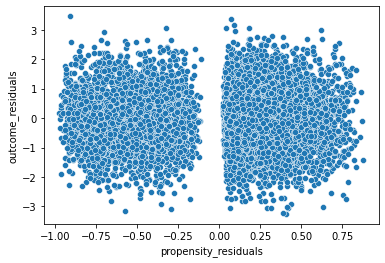

In [ ]:
sns.scatterplot(data=df, x="propensity_residuals", y="outcome_residuals")

From the picture it is hard to tell if there is any relationship. Can we have some numbers?

It turns out we have an established measure on the dependence between two random variables in information theory. This measure is called [mutual information](https://en.wikipedia.org/wiki/Mutual_information) (MI). If two random variables are independent, then their MI is equal to 0. Otherwise it will be above 0.

Its sample counterpart is a statistics that measures the dependence of two random samples. `scikit-learn` has an [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) under its `feature_selection` module (yes the intended way to use it is to do feature selection, feel free to explore this usage). 

I use the following code snippet to compute MI. It is light wrapper of `mutual_info_regression` that ensures the input has the desired shape and the output is a scalar.

In [ ]:
def compute_mutual_info(
    propensity_residuals: pd.Series, outcome_residuals: pd.Series
) -> float:
    mutual_info = mutual_info_regression(
        X=propensity_residuals.values.reshape(-1, 1),
        y=outcome_residuals,
    )
    return mutual_info.item()

In [ ]:
mutual_info = compute_mutual_info(df["propensity_residuals"], df["outcome_residuals"])

Unfortunately, the distribution of the sample MI is unclear (Hutter 2002 has a Bayesian posterior derivation, but its frequentist derivation to my knowledge does not exist yet). But, under the null hypothesis, it is very easy to bootstrap its distribution and compute the p value.

The idea of the bootstrap is quite simple. Under the null hypothesis, the two residuals are independent. So, any re-sample should not change the statistical behavior of the two residual samples. Re-sample, on the other hand, guarantees independence. So conversely if the two sets of residuals are not independent, then the original MI will be quite different from the re-smampled MI.

The code snippet for bootstrapping MI is given as follows.

In [ ]:
def bootstrap_mi(
    propensity_residuals: pd.Series, 
    outcome_residuals: pd.Series, 
    mutual_info: float,
) -> Tuple[float, np.array]:
    bootstrapped_mi = []
    for _ in range(1000):
        bootstrapped_mi.append(
            get_mutual_info(
                propensity_residuals.sample(frac=1, replace=True),
                outcome_residuals.sample(frac=1, replace=True),
            )
        )
    bootstrapped_mi = np.array(bootstrapped_mi)
    p_value = np.sum(bootstrapped_mi > mutual_info) / len(bootstrapped_mi)
    return p_value, bootstrapped_mi

Let's try it on the models that satisfy the ignorability assumption.

In [ ]:
p_value, _ = bootstrap_mi(df["propensity_residuals"], df["outcome_residuals"], mutual_info)
print((mutual_info, p_value))

(0, 0.498)


As expected, the sample MI of the two residuals is close to zero and the p value is also safely above 0. 

What if we have ommitted variables? Let's try the residuals that come from the wrong models.

In [ ]:
outcome_model_ov = train_lightgbm_model(
    params={"objective": "regression", "metric": "rmse"},
    lgb_dataset=lgb.Dataset(
        data=df[list('cdef') + ['treatment']],
        label=df['outcome'],
    )
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_

In [ ]:
df["_outcome_prediction_ov"] = outcome_model_ov.predict(df[list('cdef') + ['treatment']])
df["outcome_residuals_ov"] = df["outcome"] - df["_outcome_prediction_ov"]
df["propensity_residuals_ov"] = df["treatment"] - df["_score_ov"]

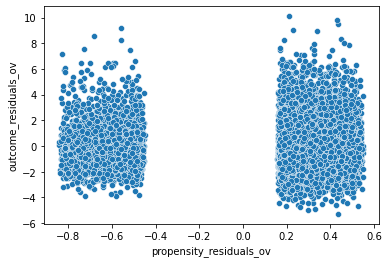

In [ ]:
sns.scatterplot(data=df, x="propensity_residuals_ov", y="outcome_residuals_ov")

It is still hard to decipher the scatterplot. Let's compute the MI and do the bootstrap.

In [ ]:
mutual_info_ov = get_mutual_info(df["propensity_residuals_ov"], df["outcome_residuals_ov"])
p_value_ov, _ = bootstrap_mi(df["propensity_residuals_ov"], df["outcome_residuals_ov"], mutual_info_ov)
print((mutual_info_ov, p_value_ov))

(0.019752510285854896, 0.003)


Compared to the case with no omitted variable, here the MI is much higher and the p value is close 0. We reject the null that there is no omitted variable.

## Summary

TBD


## References

Gu, Xing Sam, and Paul R. Rosenbaum. "Comparison of multivariate matching methods: Structures, distances, and algorithms." Journal of Computational and Graphical Statistics 2.4 (1993): 405-420.

Hutter, Marcus. "Distribution of mutual information." Advances in neural information processing systems 1 (2002): 399-406.

Masten, Matthew A., Alexandre Poirier, and Linqi Zhang. "Assessing Sensitivity to Unconfoundedness: Estimation and Inference." arXiv preprint arXiv:2012.15716 (2020).